In [345]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei')
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [346]:
pd.set_option('display.max_columns', None)  # 顯示所有列

### 十月份資料
- 缺少： **<font color = orange>1、12、13、14、21、22、23、24</font>**

dataframe僅使用：公館捷運四個出口

In [347]:
df = pd.read_csv("chained_data(把time欄位給drop掉就可以用了).csv")

In [348]:
df_test = df.dropna(subset=['tot'])
df_test['time'] = pd.to_datetime(df_test['time'])
df_test['day'] = df_test['time'].dt.day
df_test['day'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 17, 18, 19, 20, 25,
       26, 27, 28, 29, 30, 31])

In [349]:
df_test['tot'].unique()

array([12., 99., 90.])

----

### Feature Engineering

In [350]:
df['time'] = pd.to_datetime(df['time'])
df = df.rename(columns={
    "tot": "總停車格",
    "sbi": "目前車輛數量",
    "bemp": "空位數量",
    "act": "全站禁用狀態"
})

In [351]:
df['day'] = df['time'].dt.day
df['Weekday'] = df['time'].dt.weekday
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['第幾周'] = df['time'].dt.strftime('%V')

weekday_mapping = {0: 'Monday', 1: 'Teusday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df['星期'] = df['Weekday'].map(weekday_mapping)

def is_weekday(weekday):
    if weekday in ['Saturday', 'Sunday']:
        return 0  # 假日
    else:
        return 1  # 工作日
df['workday'] = df['星期'].apply(is_weekday)

In [352]:
df.head(3)

time  總停車格  目前車輛數量  空位數量  全站禁用狀態  進站人數  出站人數  全天空日射量(MJ/㎡)  \
0 2023-10-02 00:00:00  12.0     0.0  12.0     1.0  42.0  21.0           0.0   
1 2023-10-02 00:10:00  12.0     0.0  12.0     1.0   1.0   0.0           0.0   
2 2023-10-02 00:20:00  12.0     0.0  12.0     1.0   1.0   0.0           0.0   

   最大瞬間風(m/s)  最大瞬間風風向(360degree)  氣溫(℃)  海平面氣壓(hPa)  測站氣壓(hPa)  相對溼度(%)  \
0         4.7                90.0   26.5      1012.8     1009.3     83.0   
1         4.7                90.0   26.5      1012.8     1009.3     83.0   
2         4.7                90.0   26.5      1012.8     1009.3     83.0   

   紫外線指數  降水時數(h)  降水量(mm)  露點溫度(℃)  風向(360degree)  風速(m/s)     去年借車數  \
0    0.0      0.0      0.0     23.4          130.0      2.0  0.333333   
1    0.0      0.0      0.0     23.4          130.0      2.0  0.333333   
2    0.0      0.0      0.0     23.4          130.0      2.0  0.333333   

      去年還車數  is_holiday  is_hightraffic  公館2號  公館3號  公館1號  公館4號  weekday_sin  \
0  0.166667           0               0     0     0     1     0          0.0   
1  0.166667           0               0     0     0     1     0          0.0   
2  0.166667           0               0     0     0     1     0          0.0   

   weekday_cos  time_sin  time_cos  day  Weekday  hour  minute 第幾周      星期  \
0          1.0  0.000000  1.000000    2        0     0       0  40  Monday   
1          1.0  0.021815  0.999762    2        0     0      10  40  Monday   
2          1.0  0.043619  0.999048    2        0     0      20  40  Monday   

   workday  
0        1  
1        1  
2        1

先都補0

In [353]:
# df_filter = df.dropna(subset=['目前車輛數量'])
df_filter = df.copy()
columns_to_convert = ['總停車格', '目前車輛數量', '空位數量', '全站禁用狀態','降水量(mm)']
df_filter[columns_to_convert] = df_filter[columns_to_convert].fillna(0).astype(int)

In [354]:
df_filter['day_datetime'] = df_filter['hour'].astype(str) + ':' + df_filter['minute'].astype(str)
df_filter['week_datetime'] = df_filter['Weekday'].astype(str) + '-' + df_filter['hour'].astype(str) + '-' + df_filter['minute'].astype(str)

In [355]:
guan_1 = df_filter[df_filter['公館1號'] == 1]
guan_2 = df_filter[df_filter['公館2號'] == 1]
guan_3 = df_filter[df_filter['公館3號'] == 1]
guan_4 = df_filter[df_filter['公館4號'] == 1]

In [356]:
print(guan_1.shape)
print(guan_2.shape)
print(guan_3.shape)
print(guan_4.shape)

(4320, 41)
(4320, 41)
(4320, 41)
(4320, 41)


In [357]:
def calculate_rental_amount(df, vacancy_col):
    df['租借數量'] = df[vacancy_col].shift(1) - df[vacancy_col]
    df['租借數量'] = df['租借數量'].fillna(0).astype(int)
    df['租借數量'] = df['租借數量'] * -1
    return df

In [358]:
guan_1 = calculate_rental_amount(guan_1, '空位數量')
guan_2 = calculate_rental_amount(guan_2, '空位數量')
guan_3 = calculate_rental_amount(guan_3, '空位數量')
guan_4 = calculate_rental_amount(guan_4, '空位數量')

## EDA

### **<font color = orange>Data Distribution Visualization - Part 1</font>**

In [359]:
cleaned_data = df_filter.dropna()
cleaned_data = cleaned_data.iloc[:, :24]

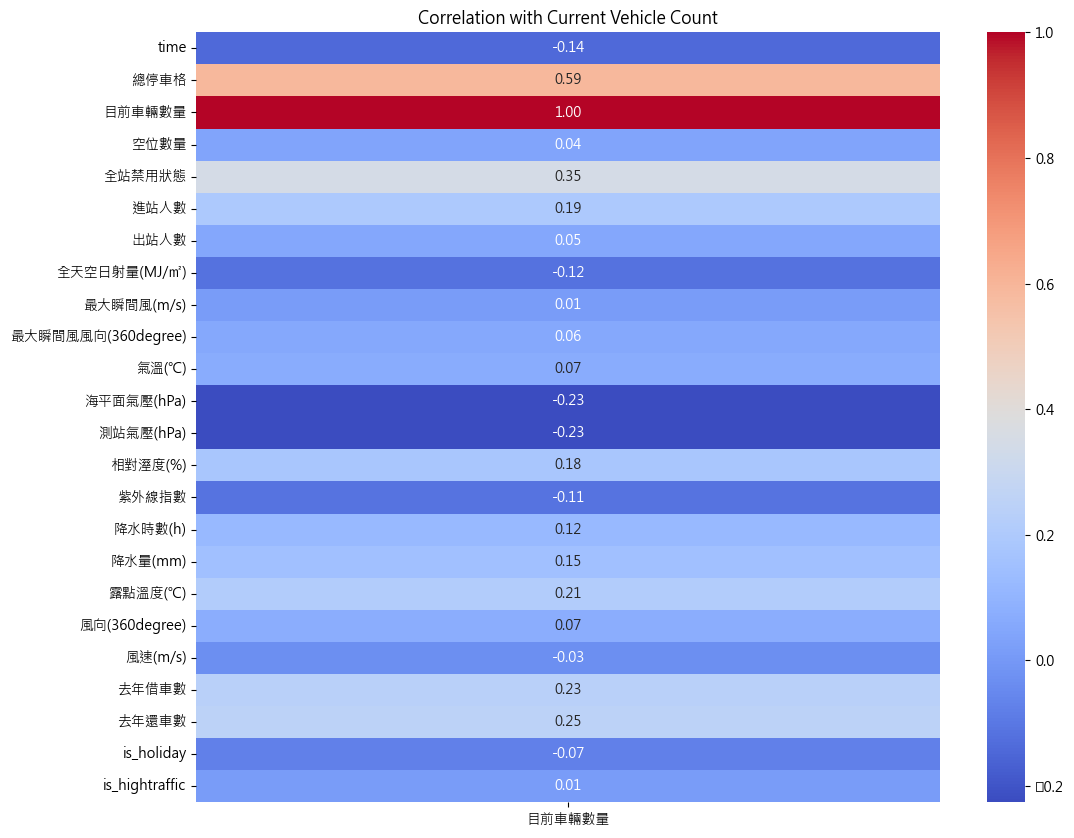

In [360]:
correlation = cleaned_data.corr()[['目前車輛數量']]
# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation with Current Vehicle Count")
plt.show()

### **<font color = orange>Data Distribution Visualization - Part 2</font>**

租借數量是否有明顯的週期性

In [361]:
# picture = guan_1
# picture = guan_2
picture = guan_3
# picture = guan_4

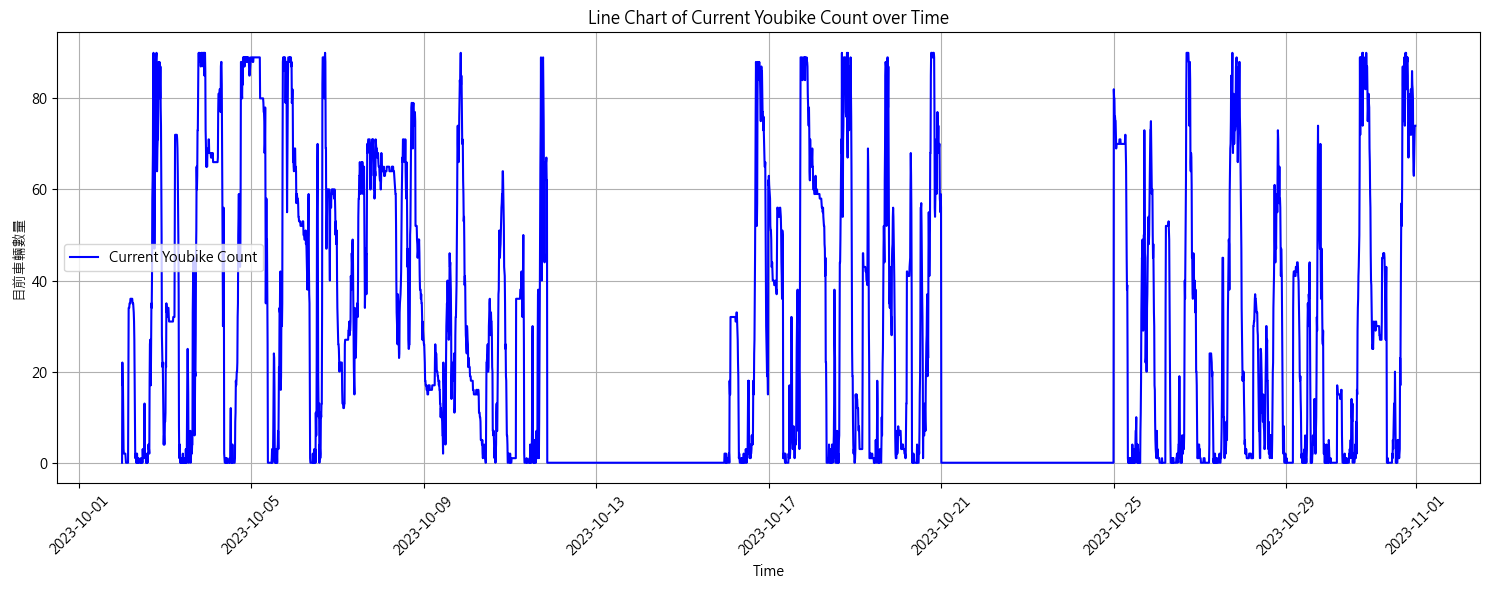

In [362]:
# Plotting the line graph for current vehicle count over time
plt.figure(figsize=(15, 6))
plt.plot(picture['time'], picture['目前車輛數量'], label='Current Youbike Count', color='blue')
plt.xlabel('Time')
plt.ylabel('目前車輛數量')
plt.title('Line Chart of Current Youbike Count over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Section 1：Per minute

In [363]:
### 繪製特定星期的每週車輛數量變化。
def plot_weekly_vehicle_data(df, weekday, weeks):
    filtered_data = df[df['第幾周'].isin(weeks)]
    filtered_data = filtered_data[filtered_data['星期'] == weekday]

    # 繪圖
    plt.figure(figsize=(20, 8))
    for week in weeks:
        weekly_data = filtered_data[filtered_data['第幾周'] == week]
        plt.plot(weekly_data['day_datetime'], weekly_data['目前車輛數量'], label=f'Week {week}')

    plt.xlabel('Time')
    plt.ylabel('Current Number of Vehicles')
    plt.title(f'Current Number of Vehicles Across Weeks: {weekday}')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

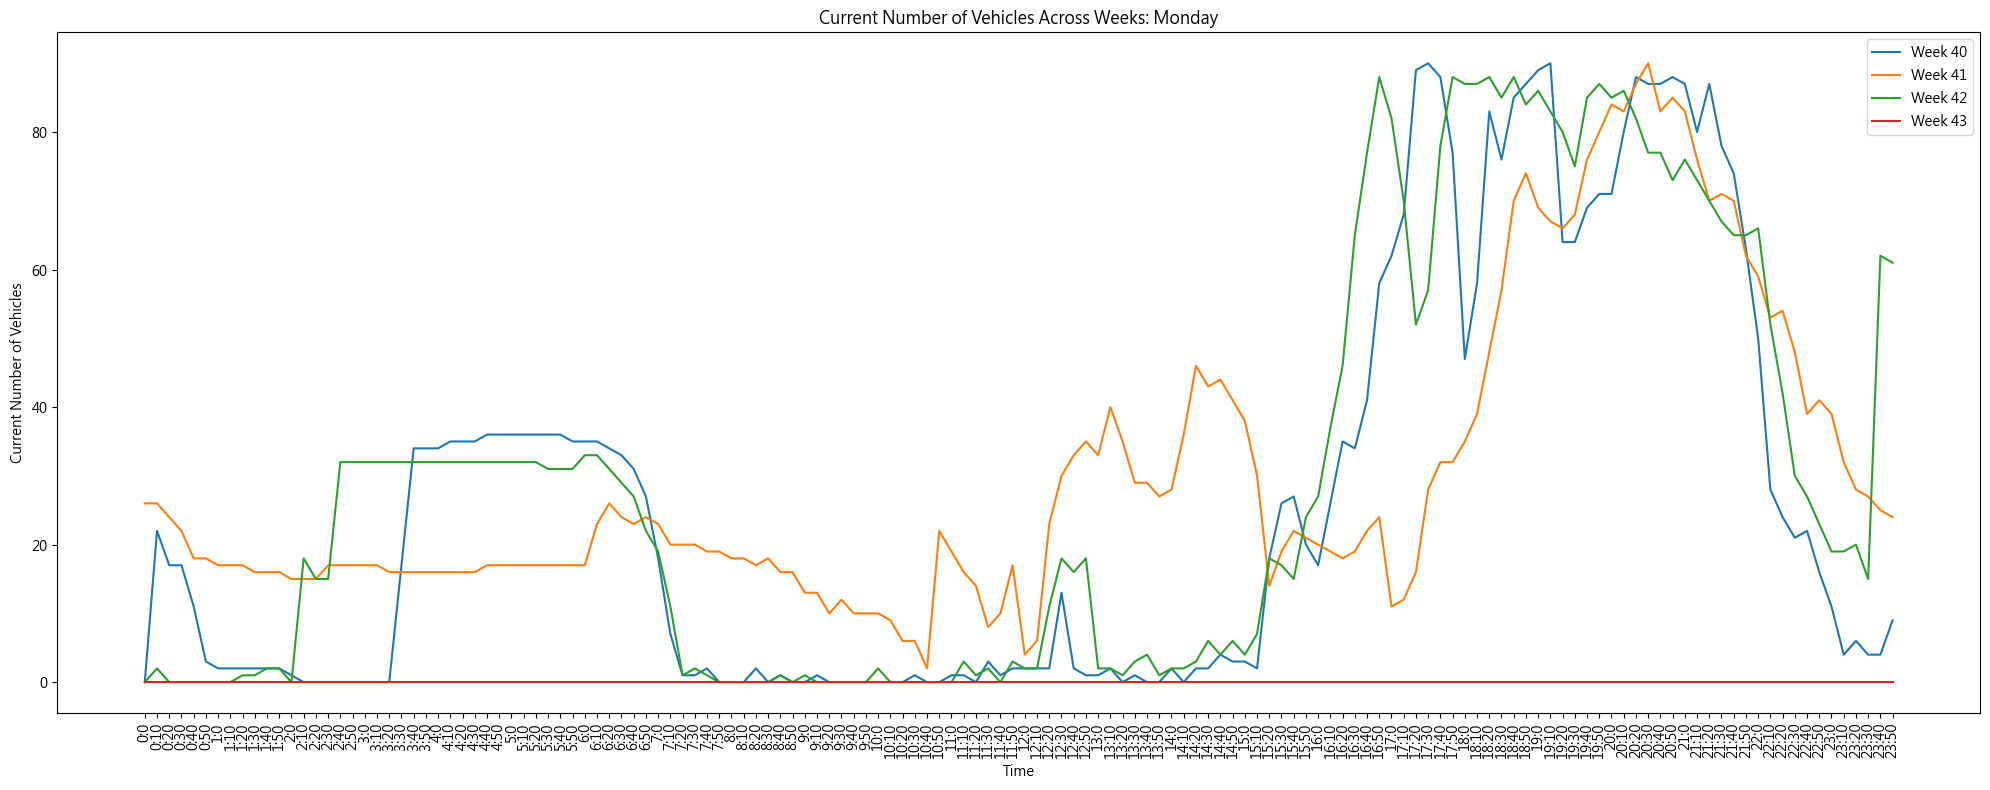

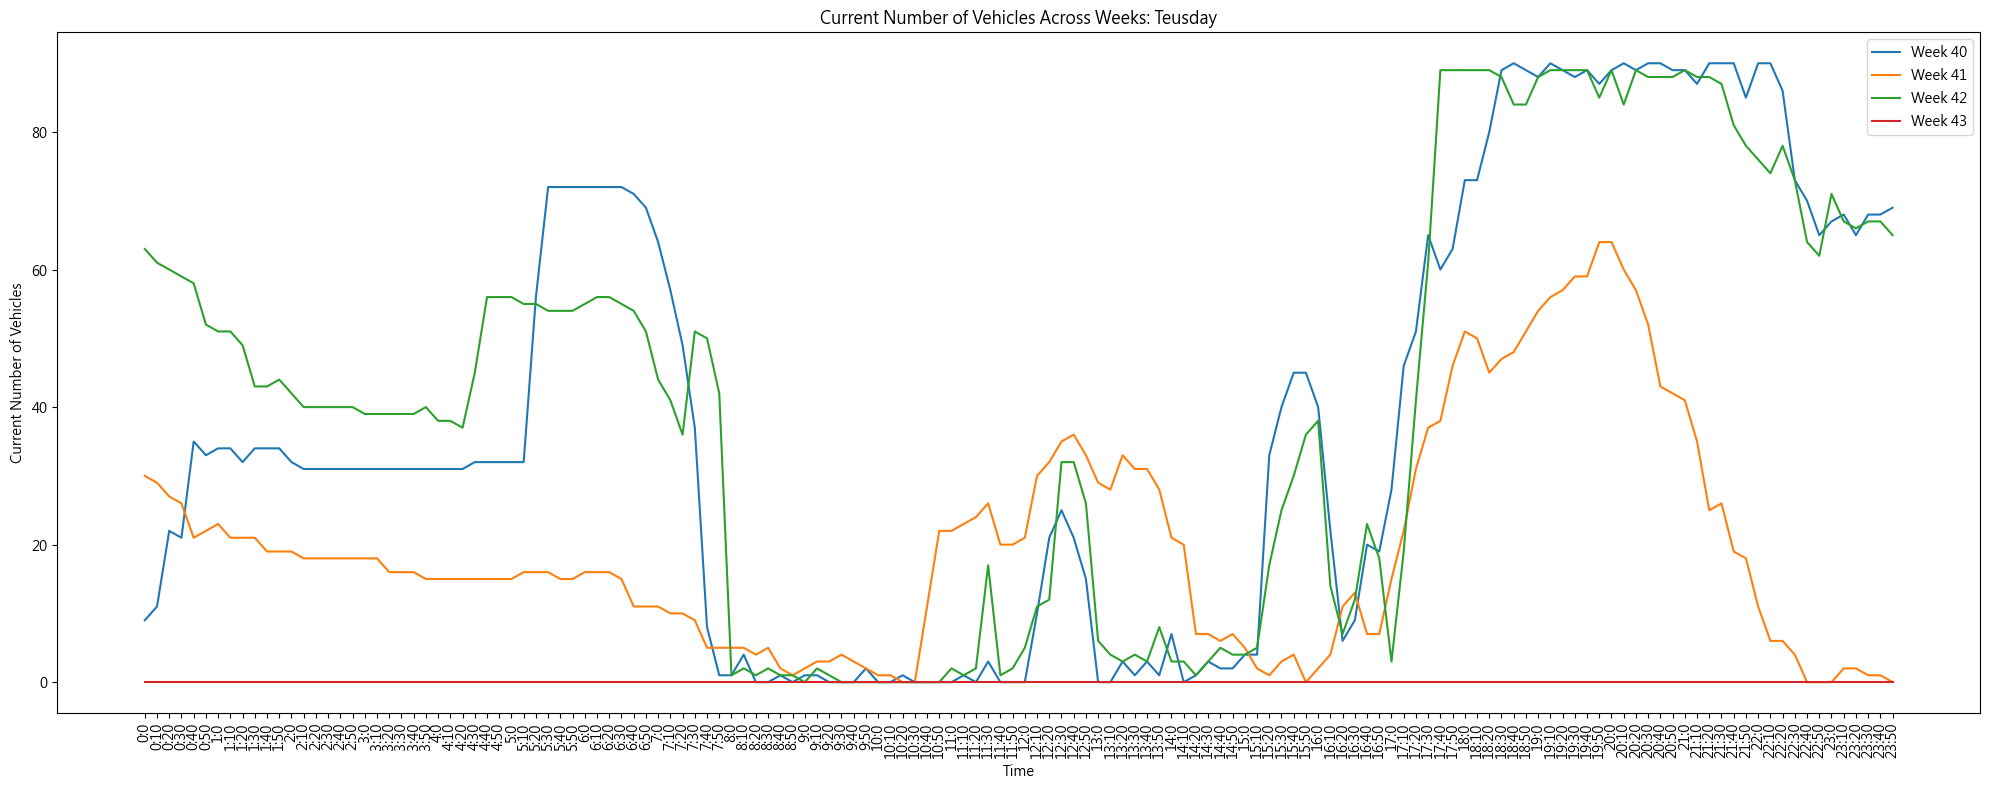

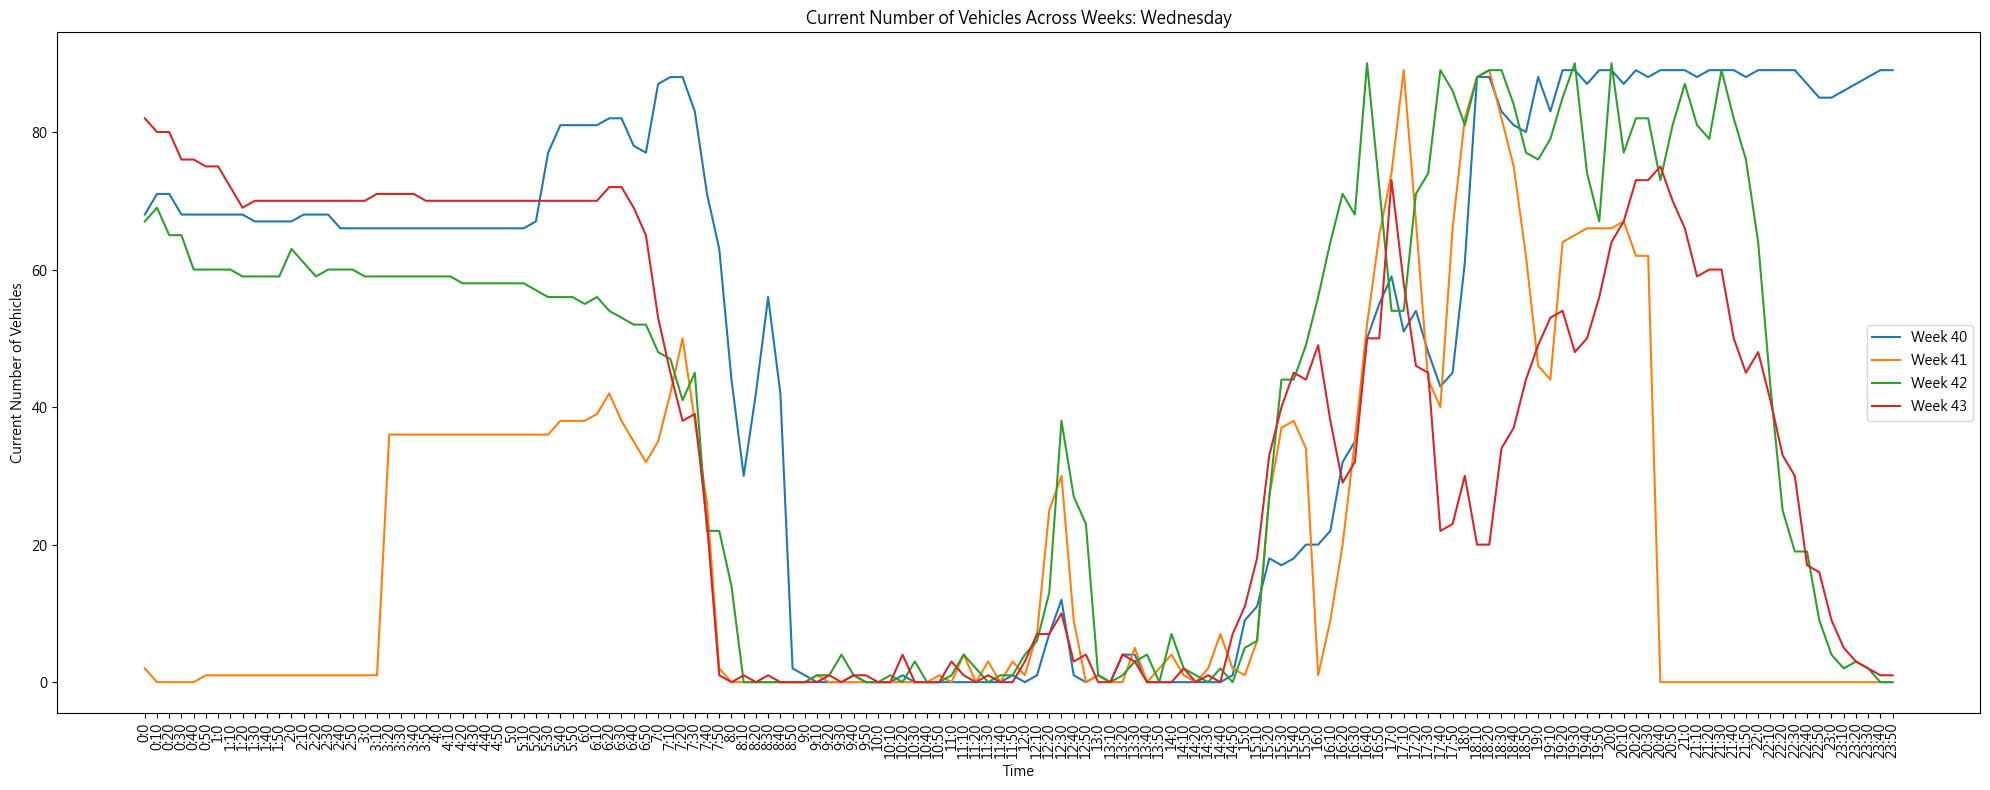

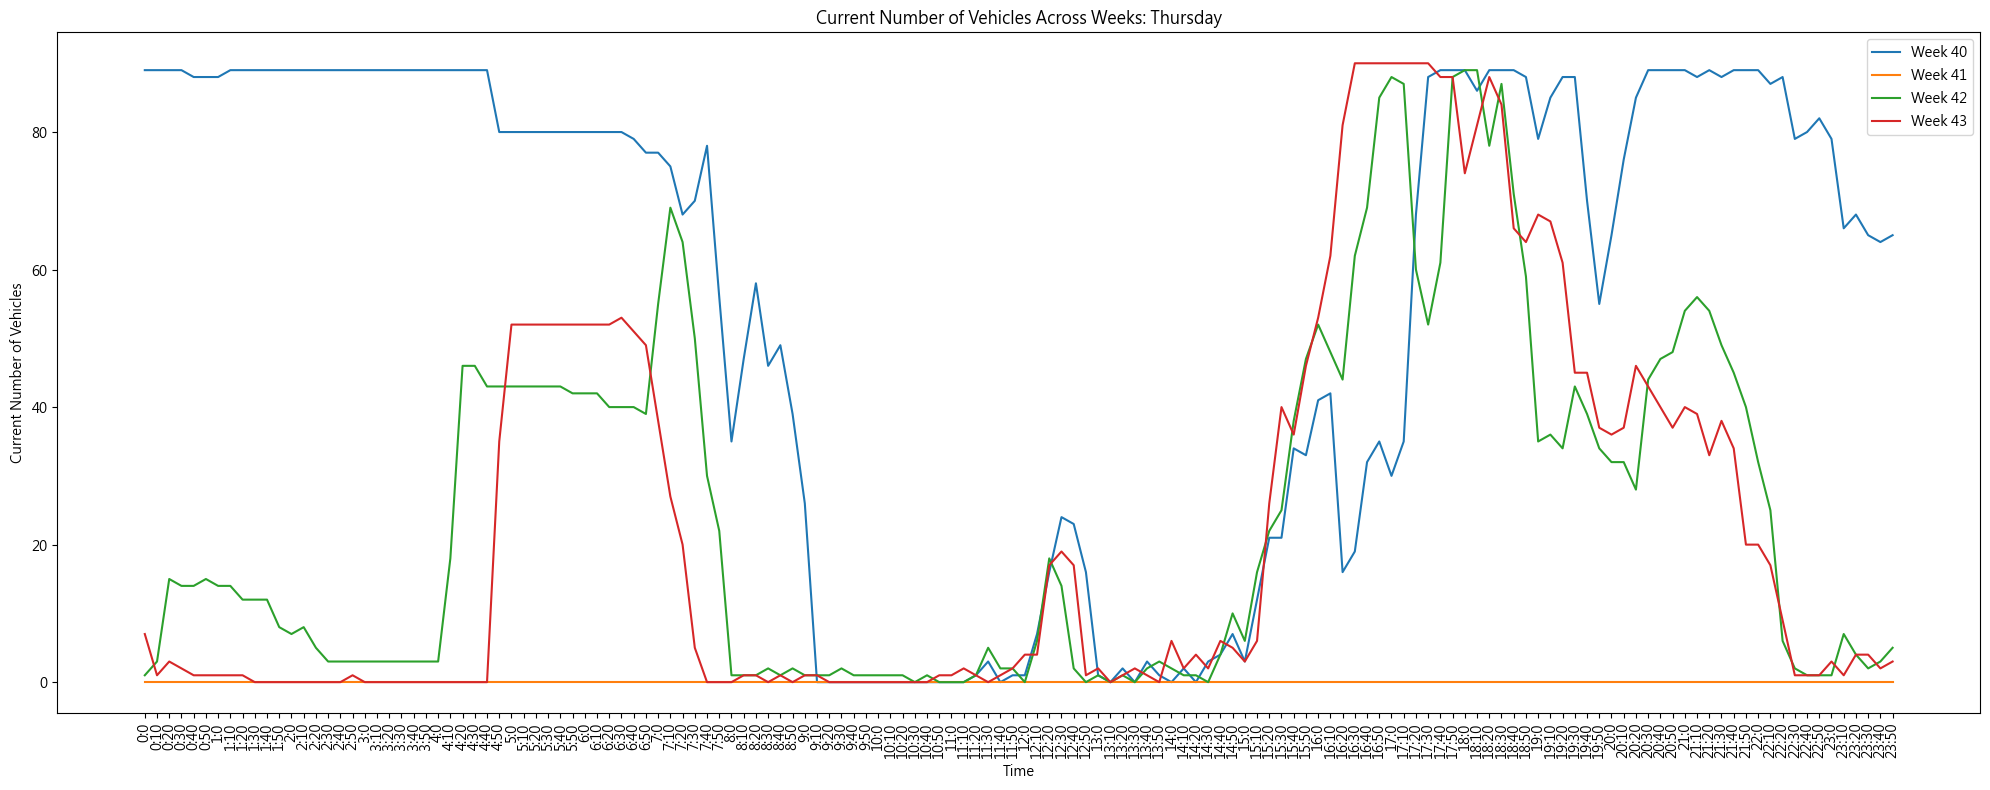

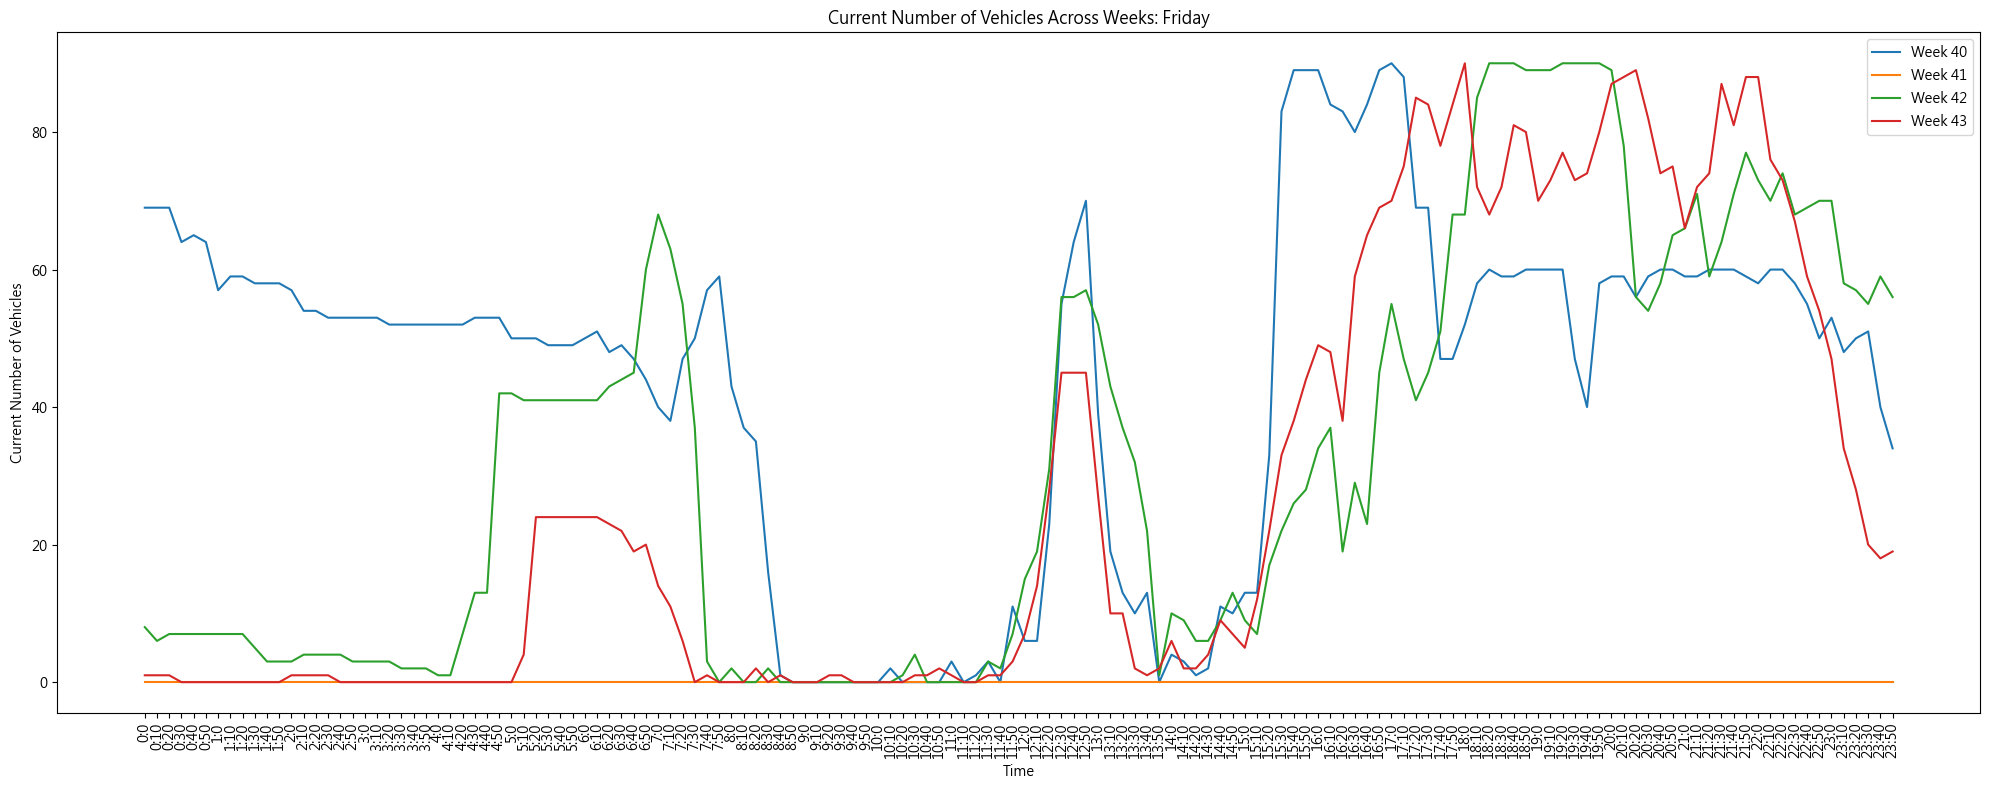

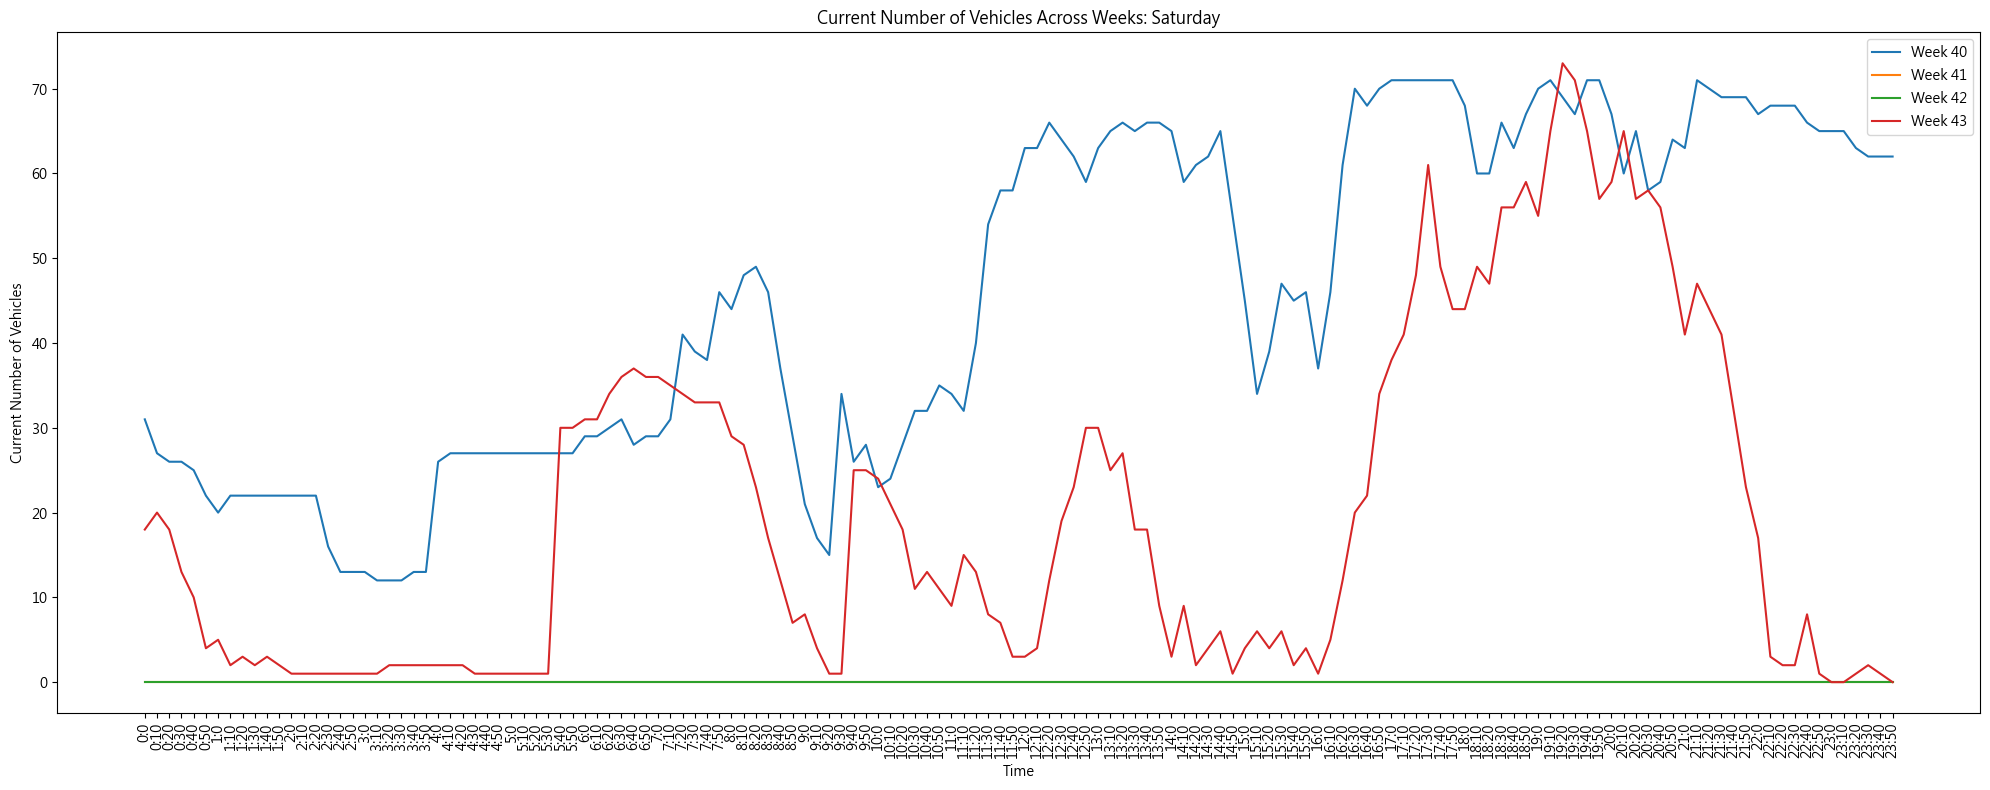

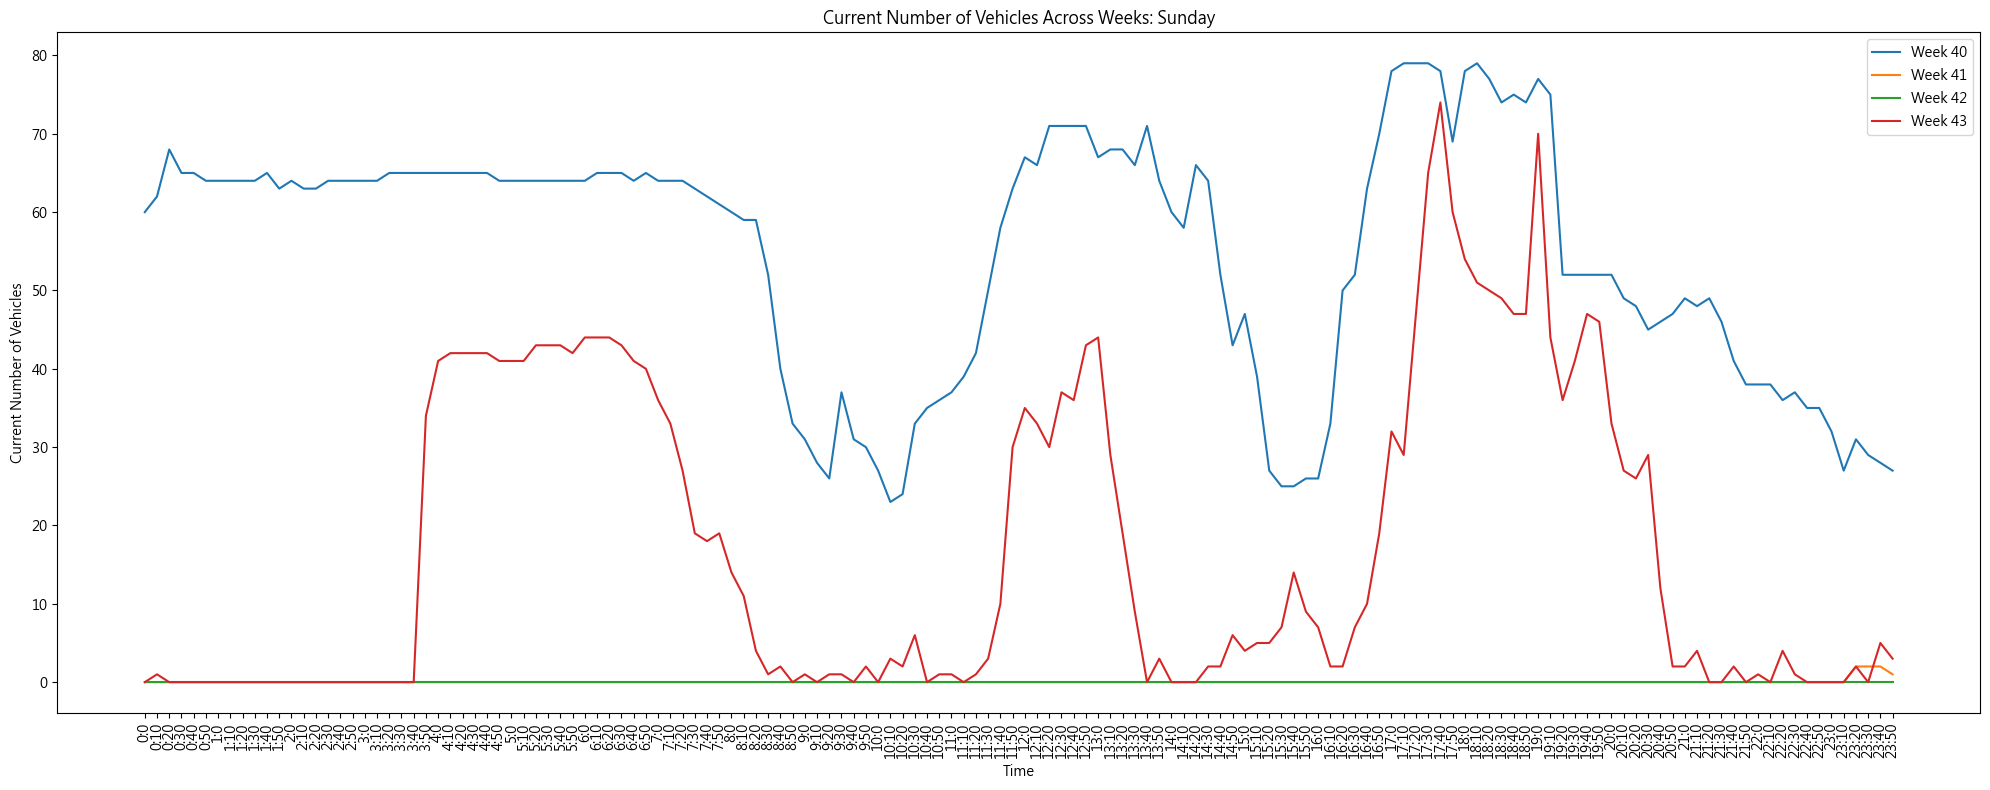

In [364]:
plot_weekly_vehicle_data(picture, 'Monday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data(picture, 'Teusday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data(picture, 'Wednesday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data(picture, 'Thursday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data(picture, 'Friday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data(picture, 'Saturday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data(picture, 'Sunday', ['40', '41', '42', '43'])

In [365]:
### 繪製特定星期的每週【租借數量】變化。
def plot_weekly_vehicle_data_rent_diff(df, weekday, weeks):
    filtered_data = df[df['第幾周'].isin(weeks)]
    filtered_data = filtered_data[filtered_data['星期'] == weekday]

    # 繪圖
    plt.figure(figsize=(20, 8))
    for week in weeks:
        weekly_data = filtered_data[filtered_data['第幾周'] == week]
        plt.plot(weekly_data['day_datetime'], weekly_data['租借數量'], label=f'Week {week}')

    plt.xlabel('Time')
    plt.ylabel('Current Number of Vehicles')
    plt.title(f'Current Number of Vehicles Across Weeks: {weekday}')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

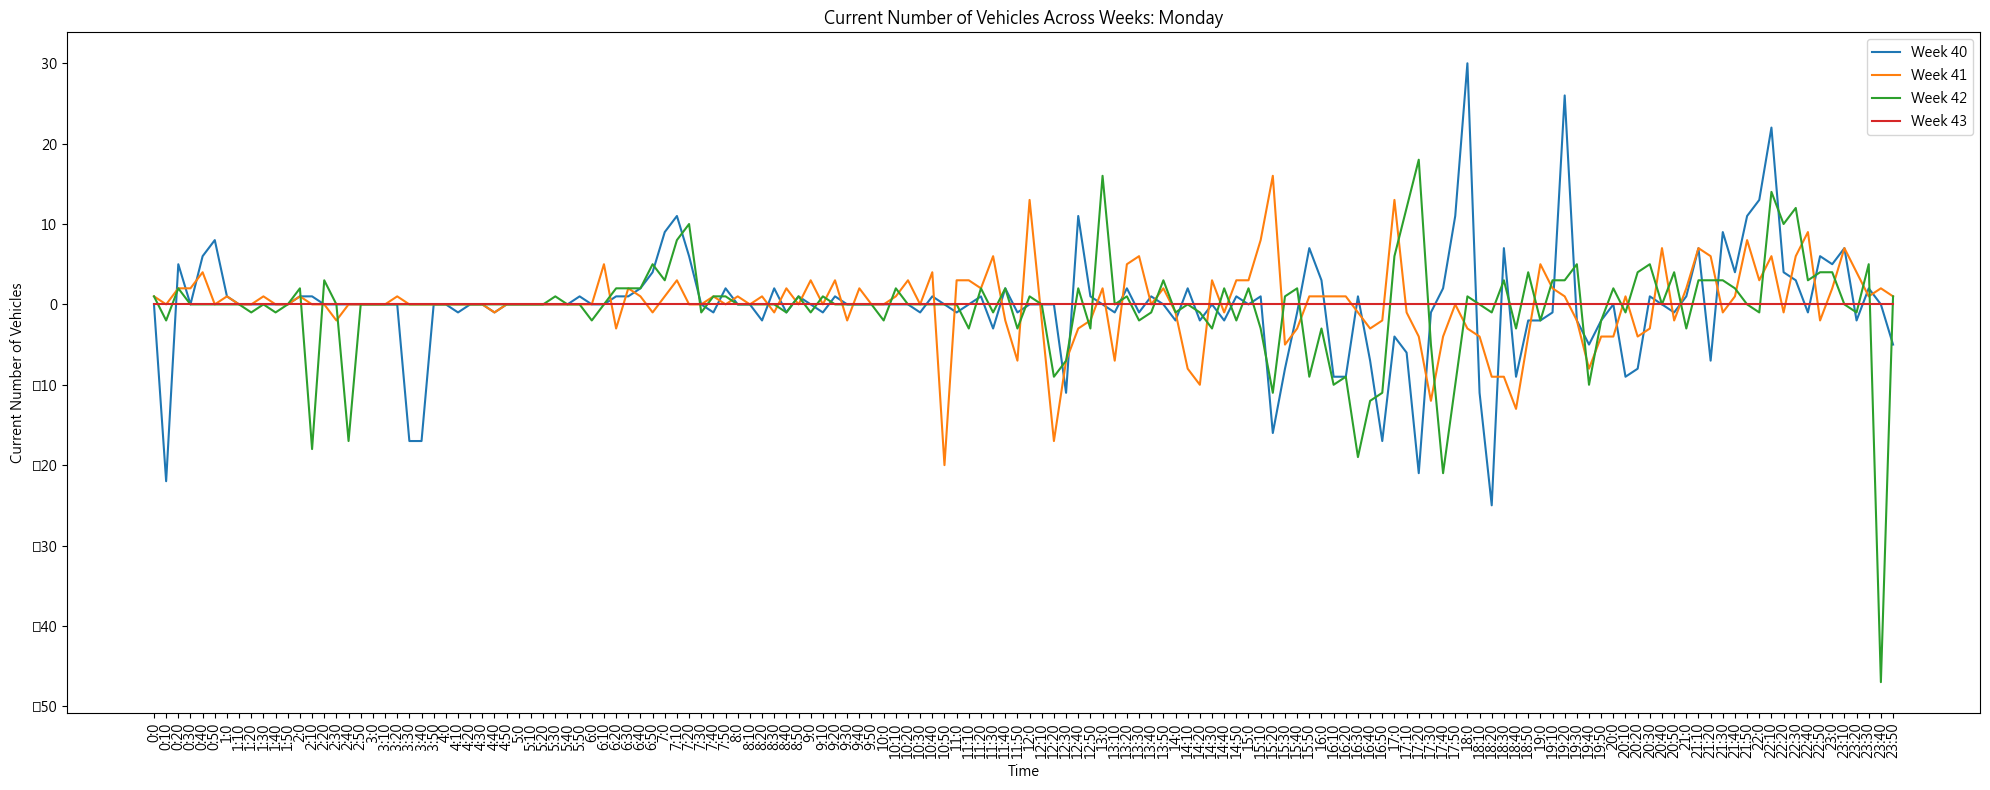

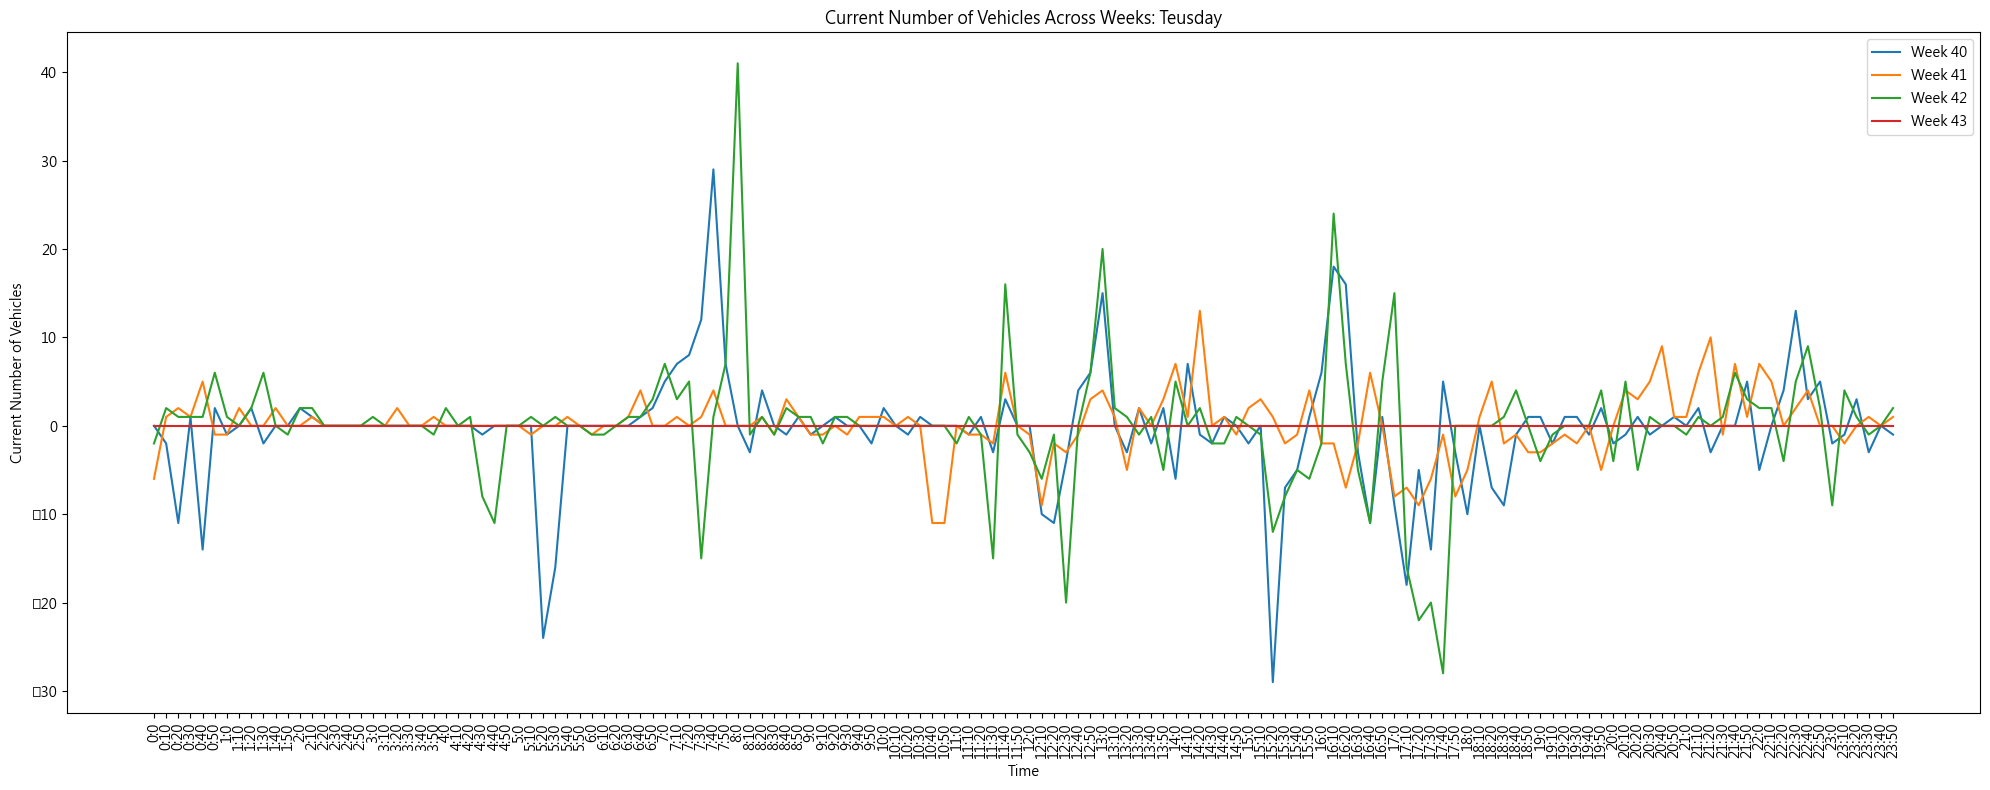

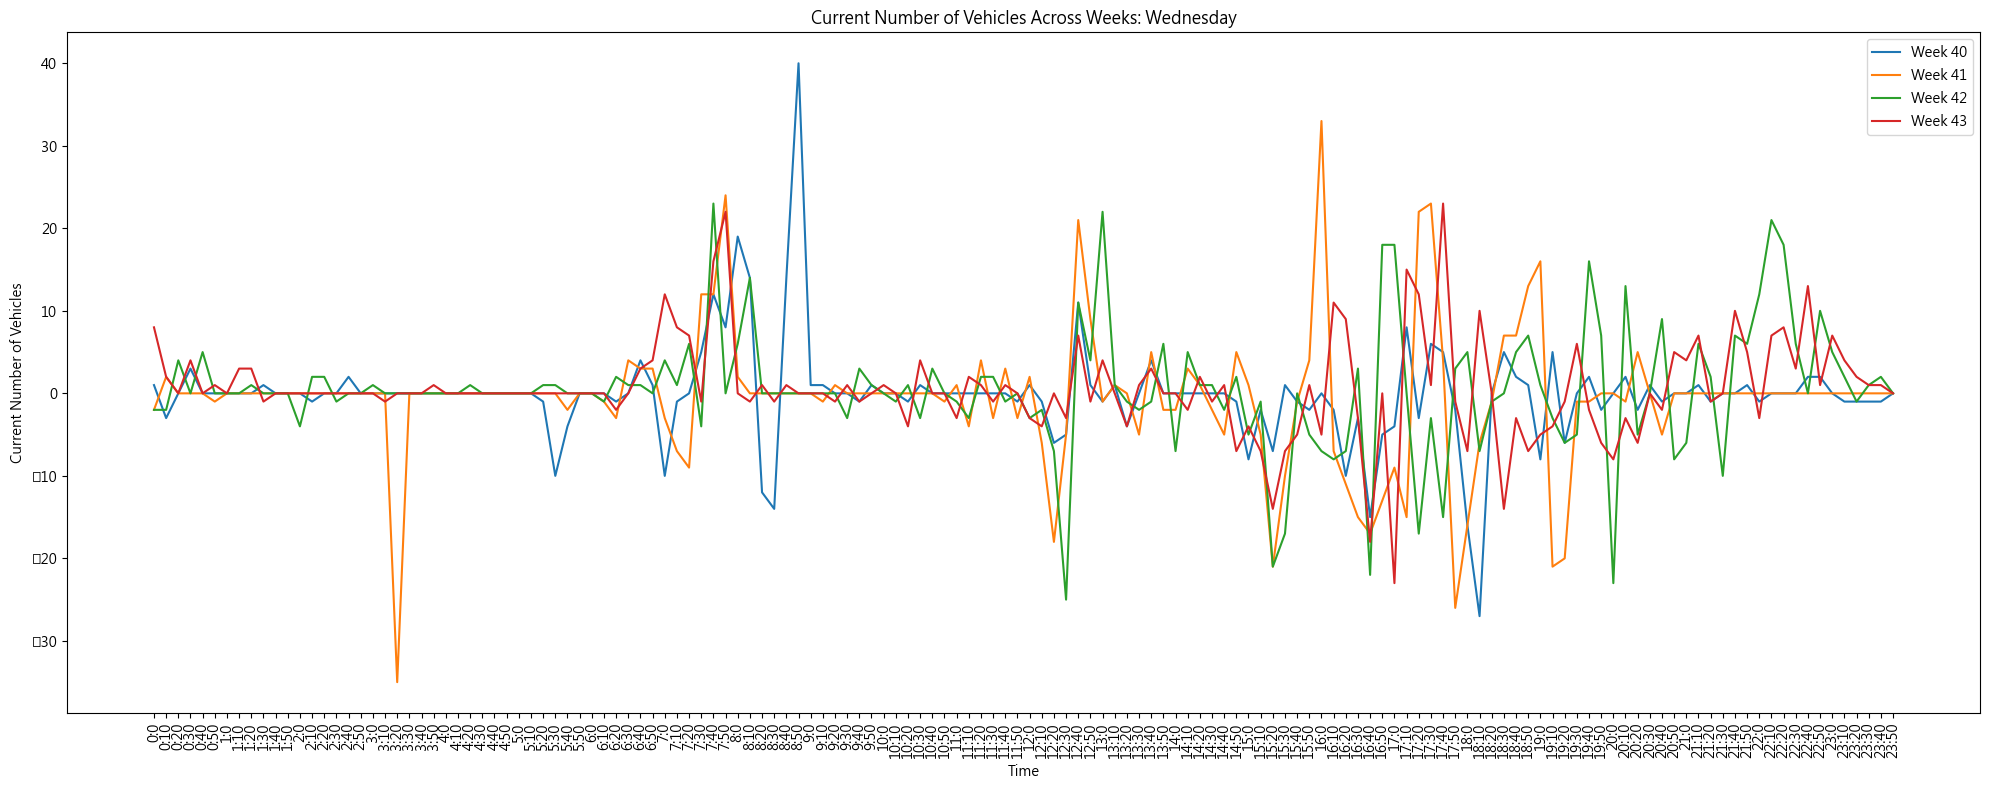

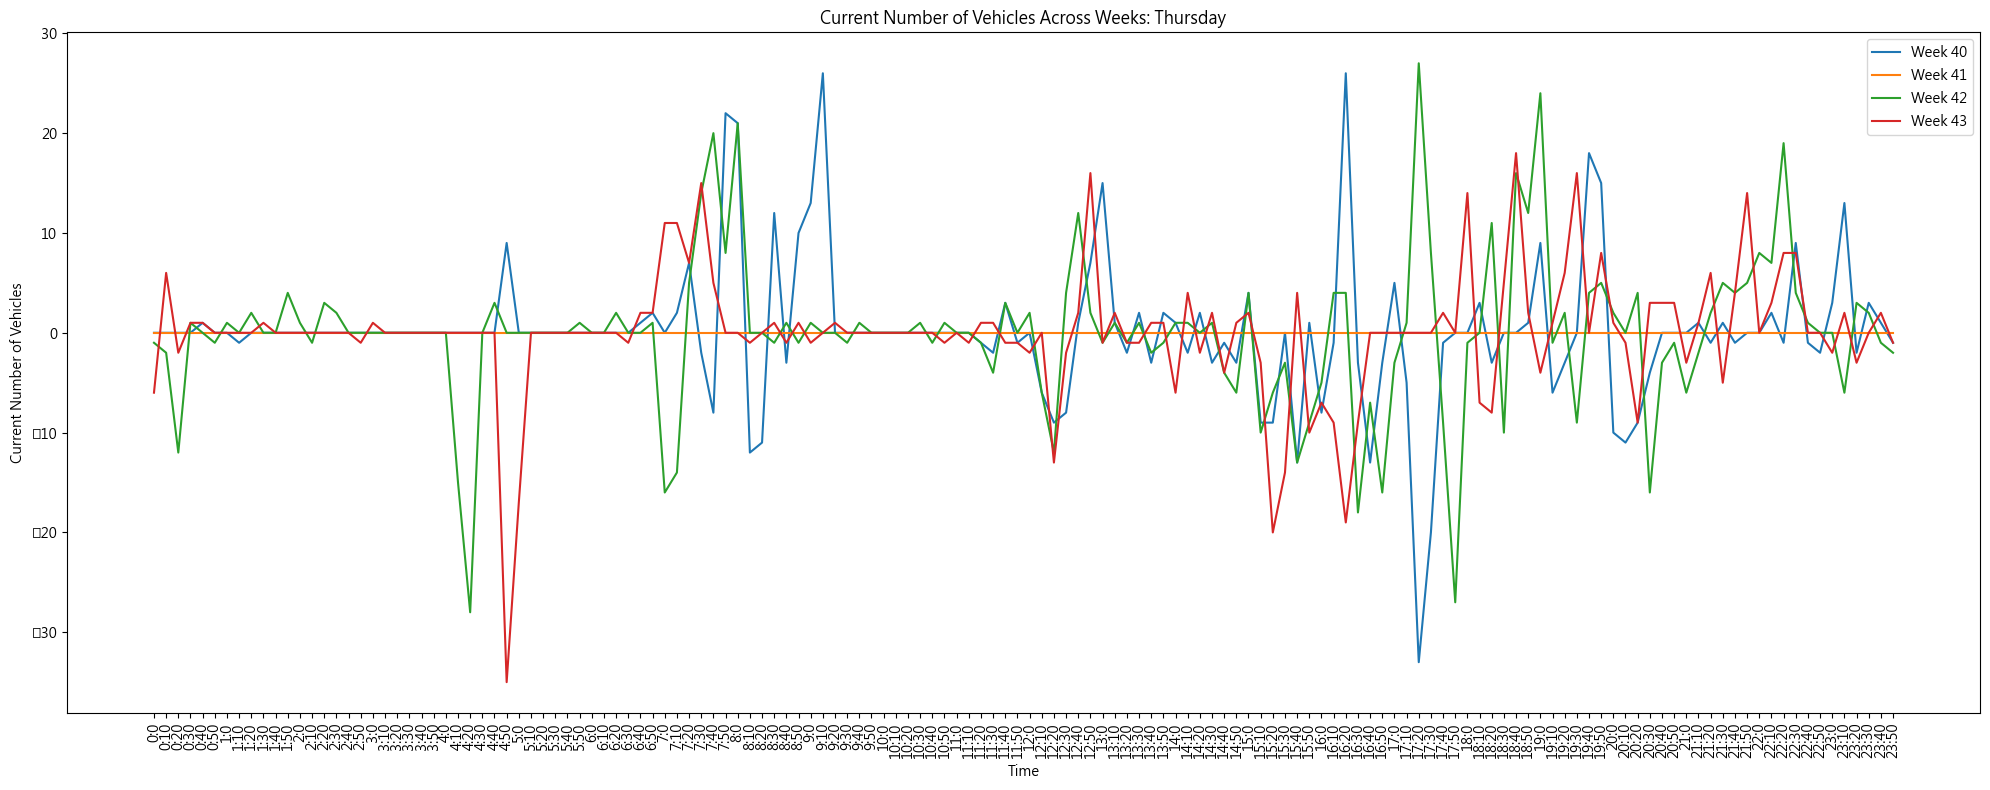

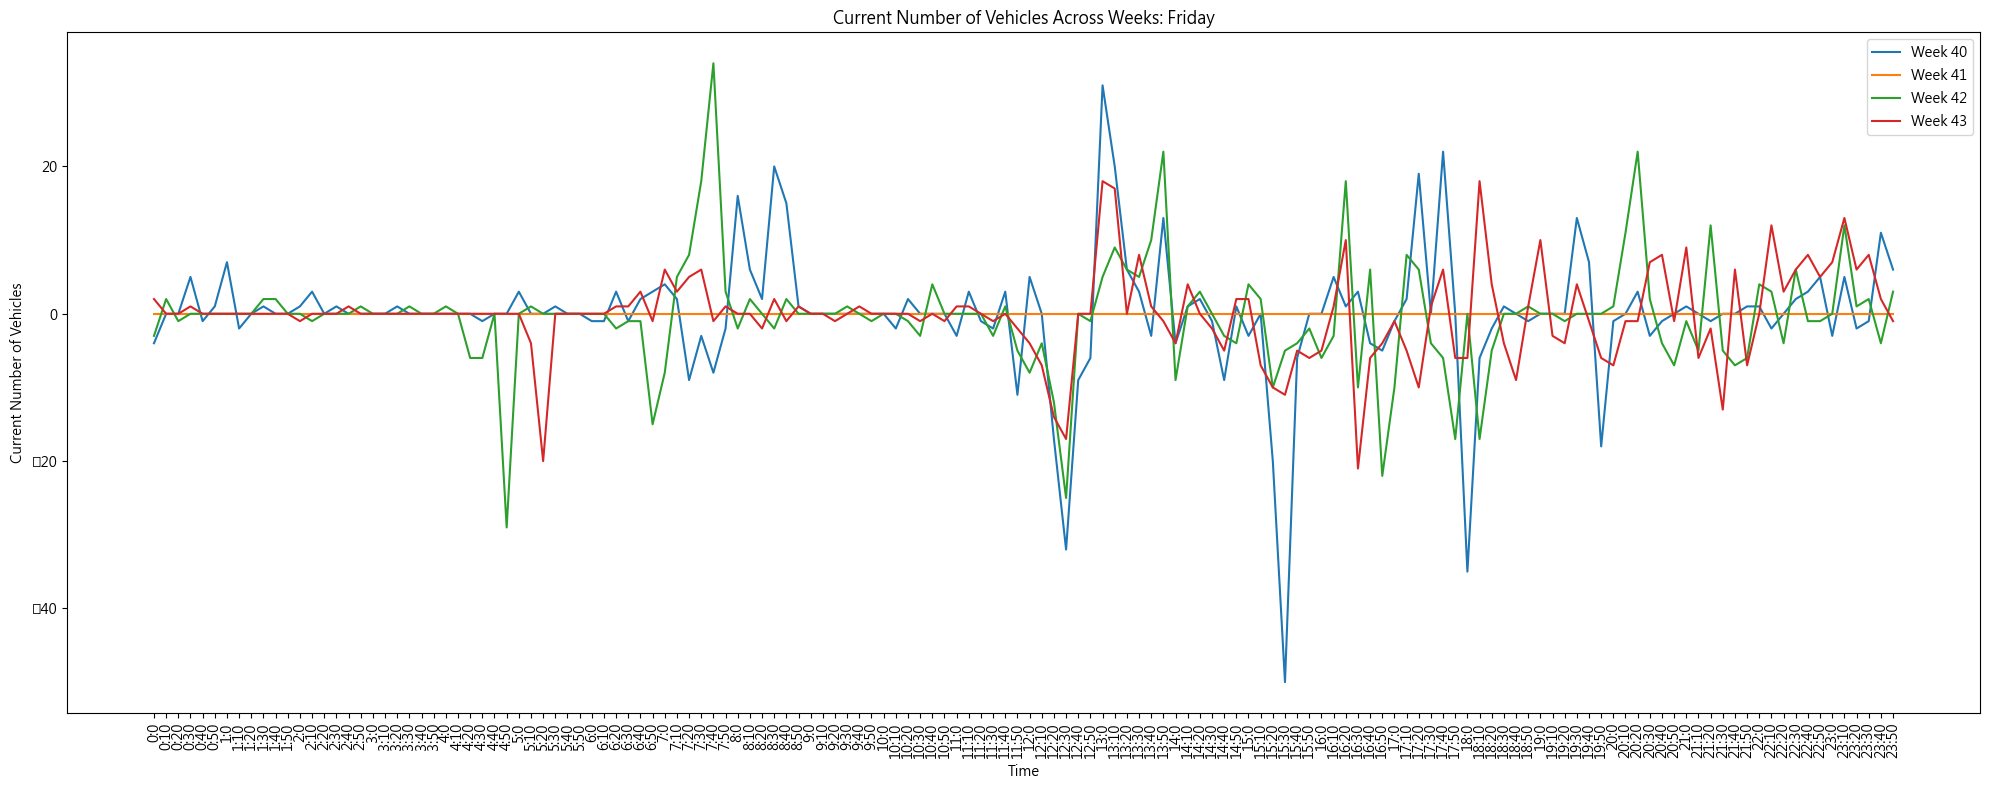

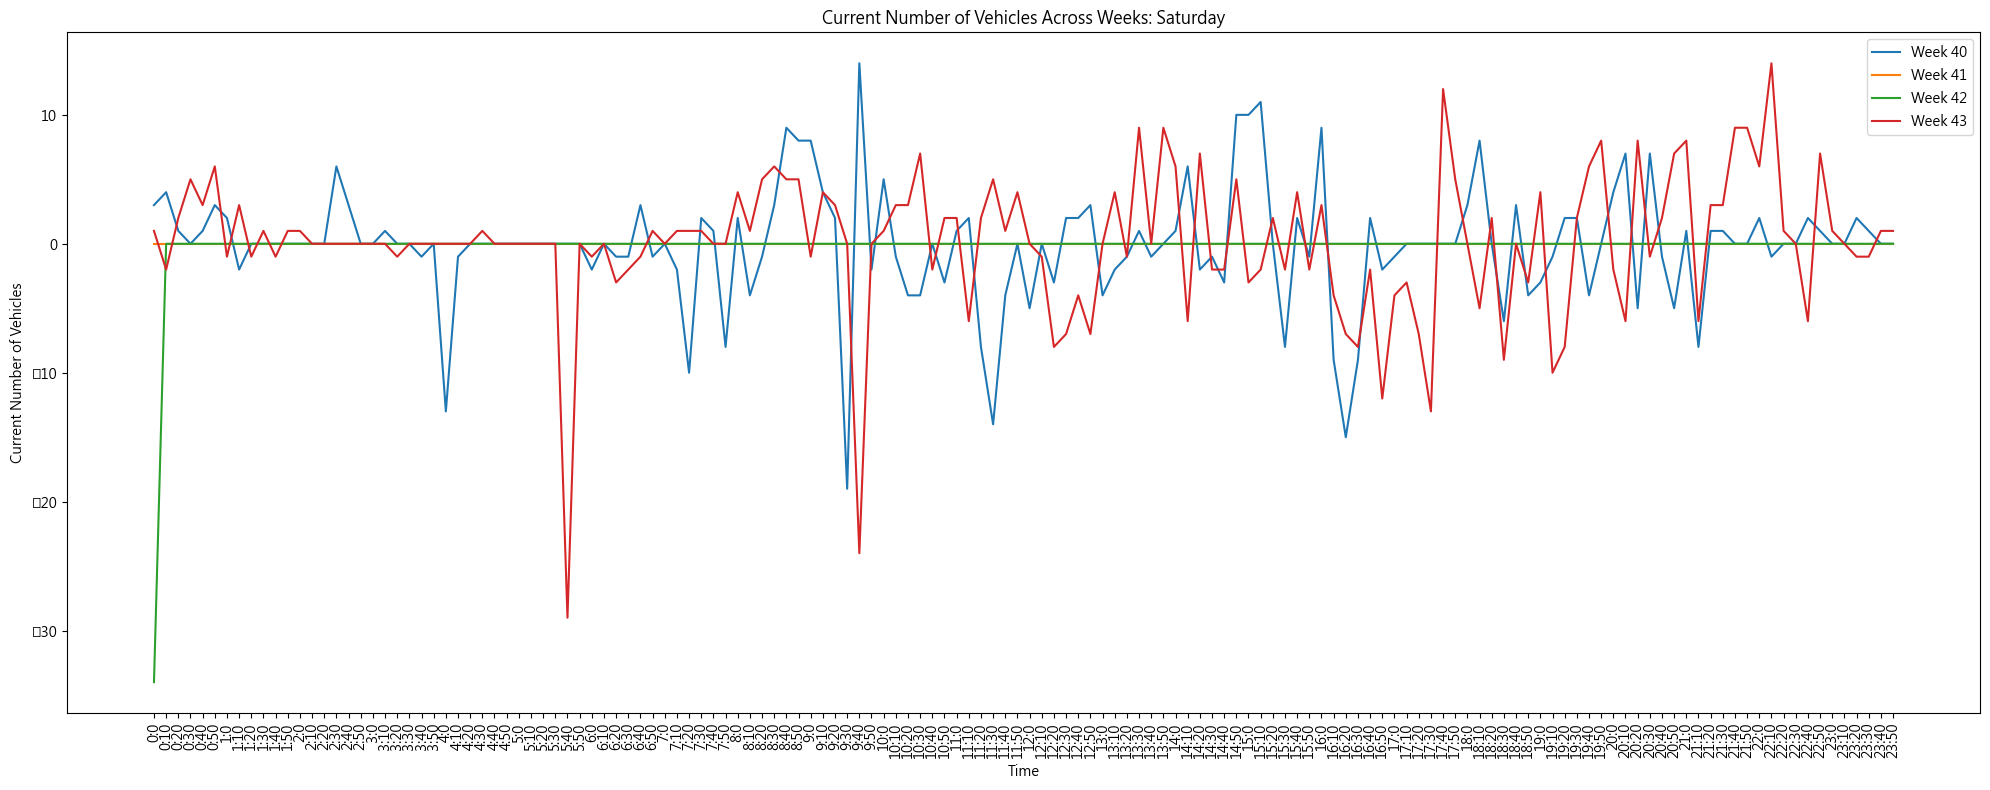

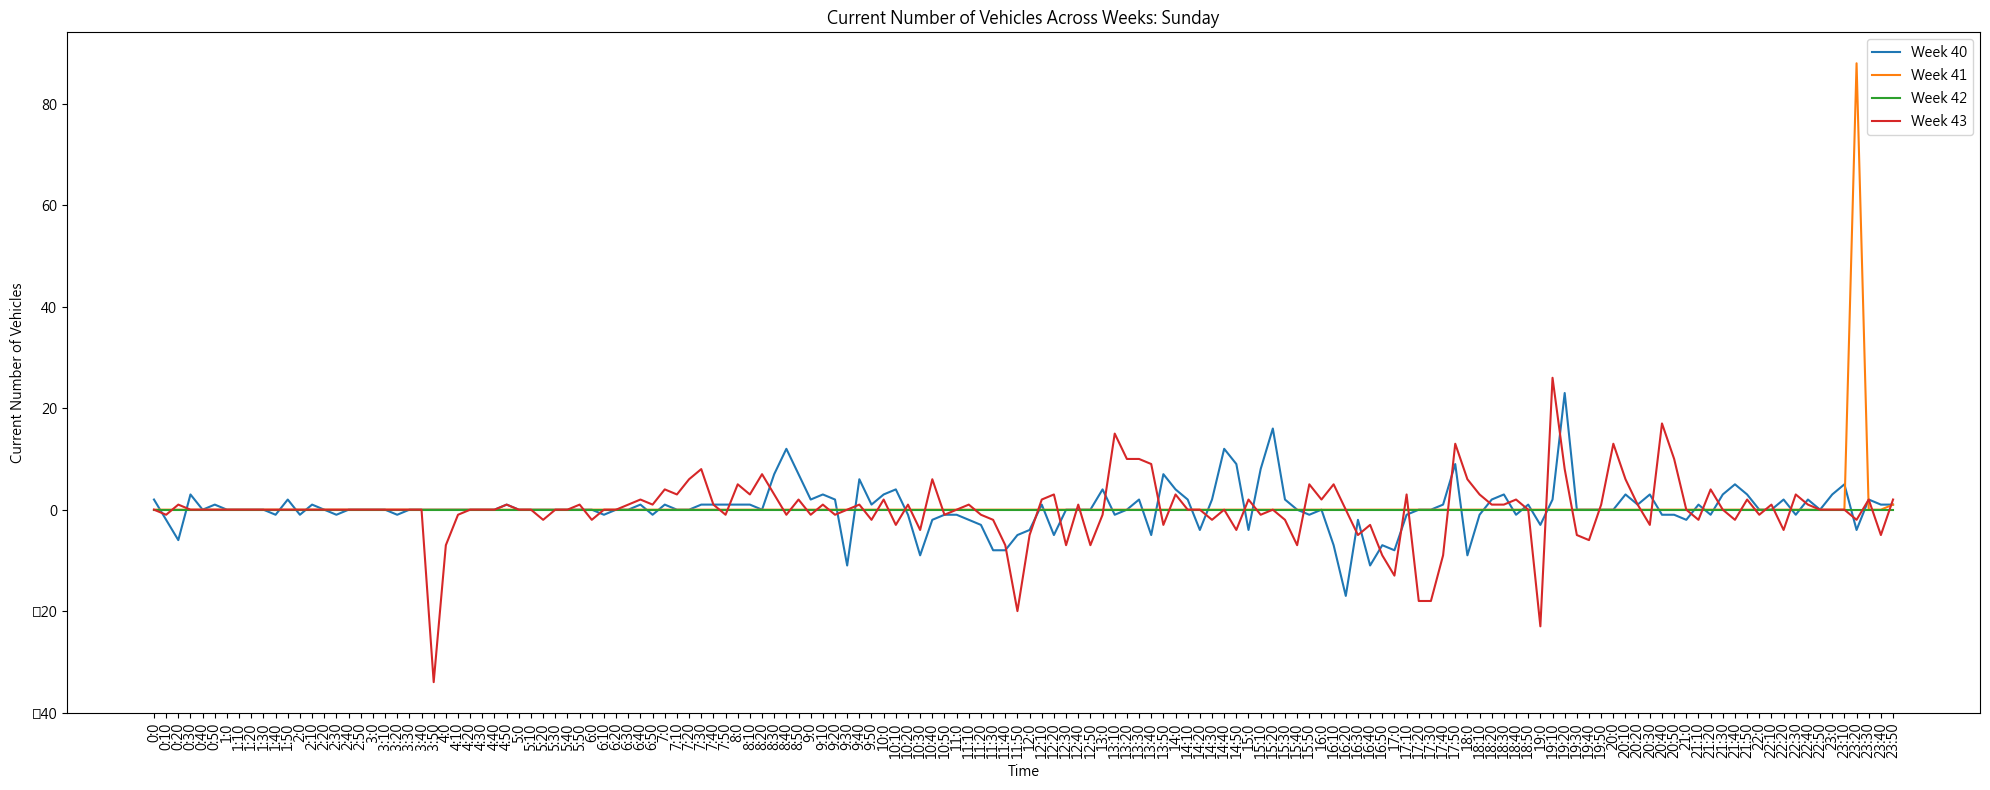

In [366]:
plot_weekly_vehicle_data_rent_diff(picture, 'Monday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data_rent_diff(picture, 'Teusday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data_rent_diff(picture, 'Wednesday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data_rent_diff(picture, 'Thursday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data_rent_diff(picture, 'Friday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data_rent_diff(picture, 'Saturday', ['40', '41', '42', '43'])
plot_weekly_vehicle_data_rent_diff(picture, 'Sunday', ['40', '41', '42', '43'])

In [367]:
picture.head(3)

time  總停車格  目前車輛數量  空位數量  全站禁用狀態  進站人數  出站人數  \
8640 2023-10-02 00:00:00    90       0    90       1  42.0  21.0   
8641 2023-10-02 00:10:00    90      22    68       1   1.0   0.0   
8642 2023-10-02 00:20:00    90      17    73       1   1.0   0.0   

      全天空日射量(MJ/㎡)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  氣溫(℃)  海平面氣壓(hPa)  \
8640           0.0         4.7                90.0   26.5      1012.8   
8641           0.0         4.7                90.0   26.5      1012.8   
8642           0.0         4.7                90.0   26.5      1012.8   

      測站氣壓(hPa)  相對溼度(%)  紫外線指數  降水時數(h)  降水量(mm)  露點溫度(℃)  風向(360degree)  \
8640     1009.3     83.0    0.0      0.0        0     23.4          130.0   
8641     1009.3     83.0    0.0      0.0        0     23.4          130.0   
8642     1009.3     83.0    0.0      0.0        0     23.4          130.0   

      風速(m/s)     去年借車數     去年還車數  is_holiday  is_hightraffic  公館2號  公館3號  \
8640      2.0  0.833333  0.333333           0               0     0     1   
8641      2.0  0.833333  0.333333           0               0     0     1   
8642      2.0  0.833333  0.333333           0               0     0     1   

      公館1號  公館4號  weekday_sin  weekday_cos  time_sin  time_cos  day  Weekday  \
8640     0     0          0.0          1.0  0.000000  1.000000    2        0   
8641     0     0          0.0          1.0  0.021815  0.999762    2        0   
8642     0     0          0.0          1.0  0.043619  0.999048    2        0   

      hour  minute 第幾周      星期  workday day_datetime week_datetime  租借數量  
8640     0       0  40  Monday        1          0:0         0-0-0     0  
8641     0      10  40  Monday        1         0:10        0-0-10   -22  
8642     0      20  40  Monday        1         0:20        0-0-20     5

In [368]:
sorted_df = (picture.groupby(['day', 'hour'])['租借數量']
            .sum()
            .reset_index(name='加總')
            .sort_values(by=['day', 'hour'], ascending=True))

In [369]:
sorted_df

day  hour  加總
0      2     0  -3
1      2     1   1
2      2     2   2
3      2     3 -34
4      2     4  -2
..   ...   ...  ..
715   31    19  10
716   31    20  -6
717   31    21  -4
718   31    22  18
719   31    23 -10

[720 rows x 3 columns]

### 平日 vs 假日 

In [370]:
picture.head()

time  總停車格  目前車輛數量  空位數量  全站禁用狀態  進站人數  出站人數  \
8640 2023-10-02 00:00:00    90       0    90       1  42.0  21.0   
8641 2023-10-02 00:10:00    90      22    68       1   1.0   0.0   
8642 2023-10-02 00:20:00    90      17    73       1   1.0   0.0   
8643 2023-10-02 00:30:00    90      17    73       1   1.0   0.0   
8644 2023-10-02 00:40:00    90      11    79       1   1.0   0.0   

      全天空日射量(MJ/㎡)  最大瞬間風(m/s)  最大瞬間風風向(360degree)  氣溫(℃)  海平面氣壓(hPa)  \
8640           0.0         4.7                90.0   26.5      1012.8   
8641           0.0         4.7                90.0   26.5      1012.8   
8642           0.0         4.7                90.0   26.5      1012.8   
8643           0.0         4.7                90.0   26.5      1012.8   
8644           0.0         4.7                90.0   26.5      1012.8   

      測站氣壓(hPa)  相對溼度(%)  紫外線指數  降水時數(h)  降水量(mm)  露點溫度(℃)  風向(360degree)  \
8640     1009.3     83.0    0.0      0.0        0     23.4          130.0   
8641     1009.3     83.0    0.0      0.0        0     23.4          130.0   
8642     1009.3     83.0    0.0      0.0        0     23.4          130.0   
8643     1009.3     83.0    0.0      0.0        0     23.4          130.0   
8644     1009.3     83.0    0.0      0.0        0     23.4          130.0   

      風速(m/s)     去年借車數     去年還車數  is_holiday  is_hightraffic  公館2號  公館3號  \
8640      2.0  0.833333  0.333333           0               0     0     1   
8641      2.0  0.833333  0.333333           0               0     0     1   
8642      2.0  0.833333  0.333333           0               0     0     1   
8643      2.0  0.833333  0.333333           0               0     0     1   
8644      2.0  0.833333  0.333333           0               0     0     1   

      公館1號  公館4號  weekday_sin  weekday_cos  time_sin  time_cos  day  Weekday  \
8640     0     0          0.0          1.0  0.000000  1.000000    2        0   
8641     0     0          0.0          1.0  0.021815  0.999762    2        0   
8642     0     0          0.0          1.0  0.043619  0.999048    2        0   
8643     0     0          0.0          1.0  0.065403  0.997859    2        0   
8644     0     0          0.0          1.0  0.087156  0.996195    2        0   

      hour  minute 第幾周      星期  workday day_datetime week_datetime  租借數量  
8640     0       0  40  Monday        1          0:0         0-0-0     0  
8641     0      10  40  Monday        1         0:10        0-0-10   -22  
8642     0      20  40  Monday        1         0:20        0-0-20     5  
8643     0      30  40  Monday        1         0:30        0-0-30     0  
8644     0      40  40  Monday        1         0:40        0-0-40     6

In [371]:
picture_filter = picture[picture['總停車格']!=0]

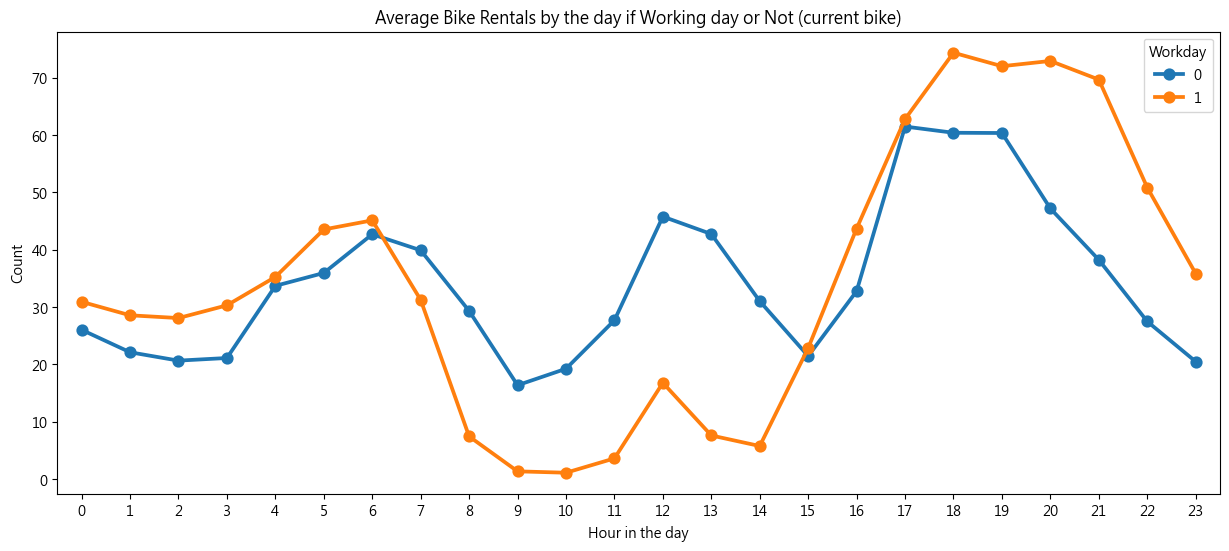

In [372]:
group_work_hour = pd.DataFrame(picture_filter.groupby(['workday', 'hour'])['目前車輛數量'].mean()).reset_index()

# 繪製點圖
plt.figure(figsize=(15, 6)) 
sns.pointplot(data=group_work_hour, x='hour', y='目前車輛數量', hue='workday')

plt.xlabel('Hour in the day')
plt.ylabel('Count')
plt.title('Average Bike Rentals by the day if Working day or Not (current bike)')
plt.legend(title='Workday')
plt.show()

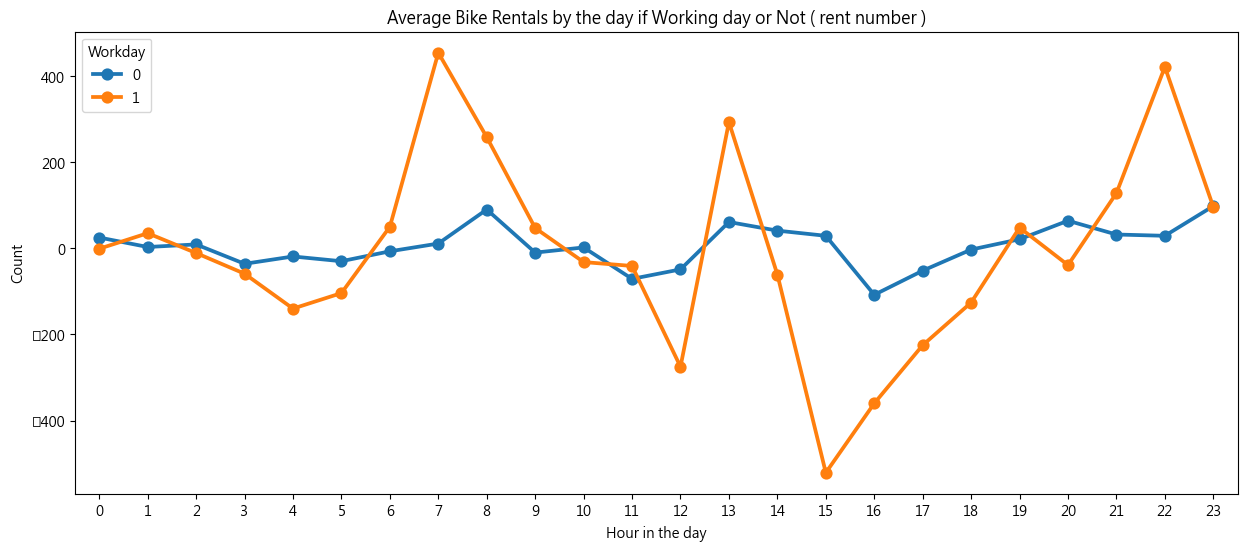

In [373]:
group_work_hour = pd.DataFrame(picture_filter.groupby(['workday', 'hour'])['租借數量'].sum()).reset_index()

# 繪製點圖
plt.figure(figsize=(15, 6)) 
sns.pointplot(data=group_work_hour, x='hour', y='租借數量', hue='workday')

plt.xlabel('Hour in the day')
plt.ylabel('Count')
plt.title('Average Bike Rentals by the day if Working day or Not ( rent number )')
plt.legend(title='Workday')
plt.show()

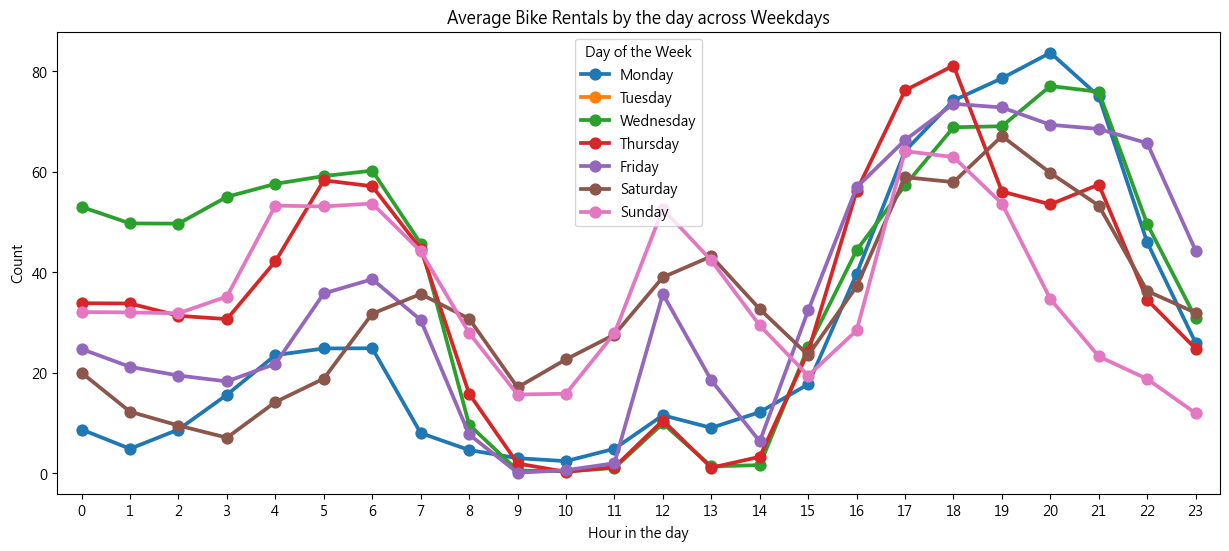

In [374]:
hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_day_hour = pd.DataFrame(picture_filter.groupby(['星期', 'hour'])['目前車輛數量'].mean()).reset_index()

plt.figure(figsize=(15, 6)) 
sns.pointplot(data=group_day_hour, x='hour', y='目前車輛數量', hue='星期', hue_order=hue_order)

plt.xlabel('Hour in the day')
plt.ylabel('Count')
plt.title('Average Bike Rentals by the day across Weekdays')
plt.legend(title='Day of the Week')
plt.show()


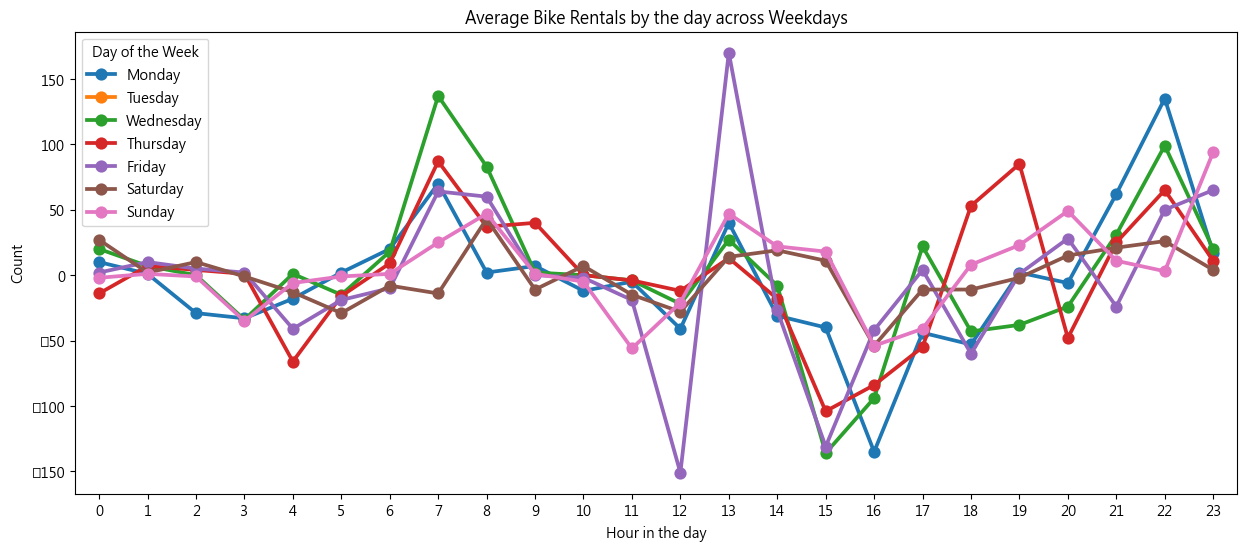

In [375]:
hue_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
group_day_hour = pd.DataFrame(picture_filter.groupby(['星期', 'hour'])['租借數量'].sum()).reset_index()


plt.figure(figsize=(15, 6))  
sns.pointplot(data=group_day_hour, x='hour', y='租借數量', hue='星期', hue_order=hue_order)

plt.xlabel('Hour in the day')
plt.ylabel('Count')
plt.title('Average Bike Rentals by the day across Weekdays')
plt.legend(title='Day of the Week')
plt.show()


In [376]:
picture_filter.head(1)

time  總停車格  目前車輛數量  空位數量  全站禁用狀態  進站人數  出站人數  全天空日射量(MJ/㎡)  \
8640 2023-10-02    90       0    90       1  42.0  21.0           0.0   

      最大瞬間風(m/s)  最大瞬間風風向(360degree)  氣溫(℃)  海平面氣壓(hPa)  測站氣壓(hPa)  相對溼度(%)  \
8640         4.7                90.0   26.5      1012.8     1009.3     83.0   

      紫外線指數  降水時數(h)  降水量(mm)  露點溫度(℃)  風向(360degree)  風速(m/s)     去年借車數  \
8640    0.0      0.0        0     23.4          130.0      2.0  0.833333   

         去年還車數  is_holiday  is_hightraffic  公館2號  公館3號  公館1號  公館4號  \
8640  0.333333           0               0     0     1     0     0   

      weekday_sin  weekday_cos  time_sin  time_cos  day  Weekday  hour  \
8640          0.0          1.0       0.0       1.0    2        0     0   

      minute 第幾周      星期  workday day_datetime week_datetime  租借數量  
8640       0  40  Monday        1          0:0         0-0-0     0

In [377]:
# 创建一个列名列表，包含您想要删除的列
columns_to_drop = [
    '公館2號', '公館3號', '公館1號', '公館4號','全站禁用狀態',
    '星期','day_datetime', 'week_datetime'
]
# 使用drop方法删除列
picture_filter.drop(columns=columns_to_drop, inplace=True)
cleaned_data = picture_filter.dropna()

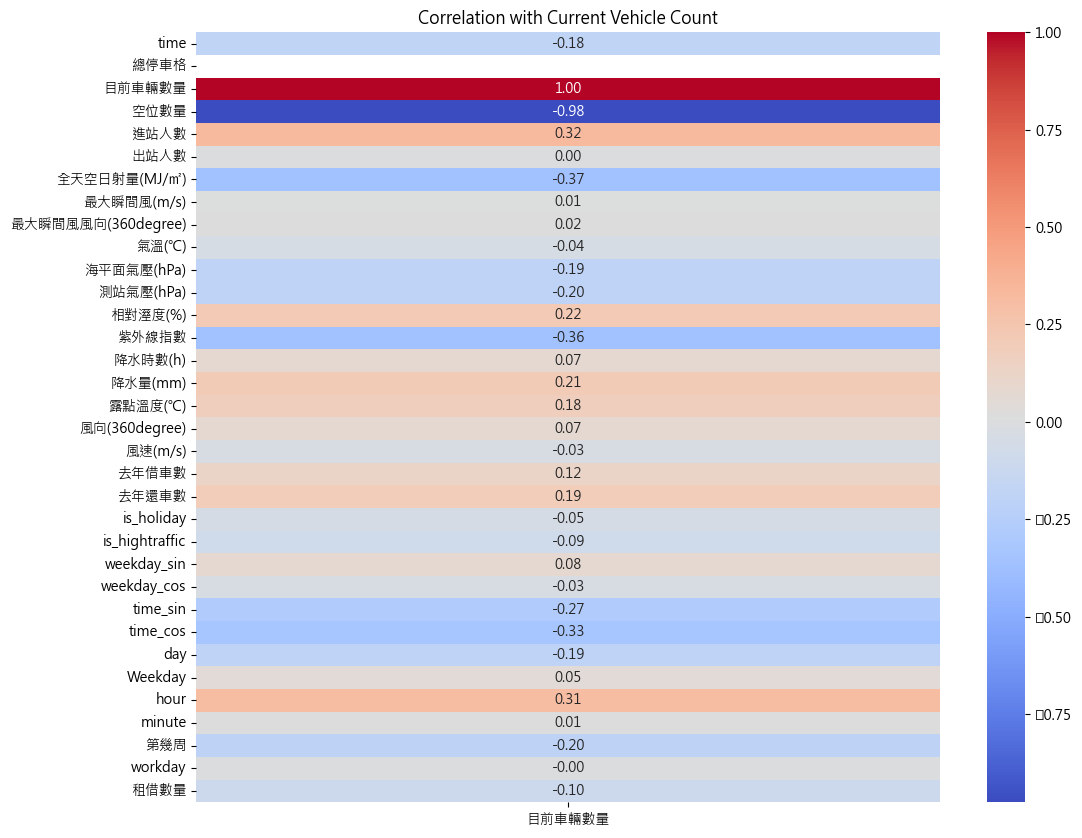

In [378]:
correlation = cleaned_data.corr()[['目前車輛數量']]
# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation with Current Vehicle Count")
plt.show()

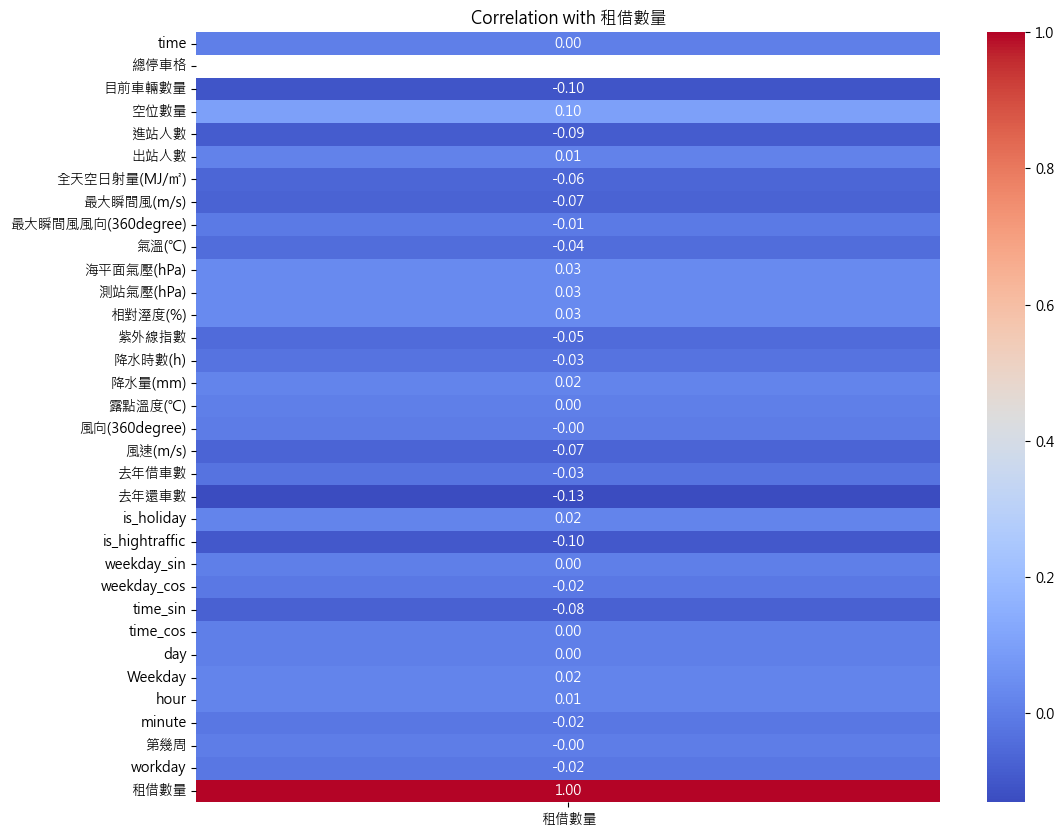

In [379]:
correlation = cleaned_data.corr()[['租借數量']]
# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation with 租借數量")
plt.show()